In [38]:
import os
import subprocess

# Set the folder paths
FOLDERNAME = r'D:\Work\Study\AI\cs231\assignment1'
DATASET_PATH = os.path.join(FOLDERNAME, 'cs231n', 'datasets')
SCRIPT_PATH = os.path.join(DATASET_PATH, 'get_datasets.sh')

# Path to Git Bash executable
GIT_BASH_PATH = r'C:\Program Files\Git\bin\bash.exe'  # Update this if your Git Bash is installed elsewhere

# Ensure the script exists
if not os.path.exists(SCRIPT_PATH):
    raise FileNotFoundError(f"[ERROR] Script not found at: {SCRIPT_PATH}")
else:
    print(f"[INFO] Script found at: {SCRIPT_PATH}")

# Run the script using Git Bash
try:
    print("[INFO] Running get_datasets.sh to download CIFAR-10 dataset...")
    result = subprocess.run(
        [GIT_BASH_PATH, '-c', f"cd '{DATASET_PATH}' && bash get_datasets.sh"],  # Run the script in Git Bash
        check=True,
        text=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    print("[INFO] Dataset download completed.")
    print("[INFO] Script output:")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print(f"[ERROR] Script execution failed with return code {e.returncode}")
    print(f"[ERROR] Command stdout: {e.stdout}")
    print(f"[ERROR] Command stderr: {e.stderr}")
except Exception as e:
    print(f"[ERROR] An unexpected error occurred: {e}")
finally:
    # Return to the assignment folder
    os.chdir(FOLDERNAME)
    print(f"[INFO] Working directory set back to: {FOLDERNAME}")


[INFO] Script found at: D:\Work\Study\AI\cs231\assignment1\cs231n\datasets\get_datasets.sh
[INFO] Running get_datasets.sh to download CIFAR-10 dataset...
[INFO] Dataset download completed.
[INFO] Script output:

[INFO] Working directory set back to: D:\Work\Study\AI\cs231\assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [39]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [41]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.405034
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Because there are 10 classes, so the predict classes is 1/10, but it's just appear when the distribution is uniform, so the data are nearly stable. 



In [42]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

(3073, 10)
numerical: 2.380589 analytic: 2.380589, relative error: 2.556018e-08
numerical: 1.309652 analytic: 1.309652, relative error: 5.808577e-08
numerical: -3.111990 analytic: -3.111990, relative error: 3.585370e-09
numerical: -2.636019 analytic: -2.636020, relative error: 9.984497e-09
numerical: 3.375915 analytic: 3.375915, relative error: 1.523883e-08
numerical: 4.221170 analytic: 4.221170, relative error: 2.106951e-08
numerical: 0.014175 analytic: 0.014174, relative error: 4.406840e-06
numerical: -1.136305 analytic: -1.136305, relative error: 4.739589e-08
numerical: -1.557031 analytic: -1.557031, relative error: 9.684350e-09
numerical: 1.109092 analytic: 1.109092, relative error: 2.055550e-08
(3073, 10)
numerical: 0.312472 analytic: 0.312472, relative error: 7.447959e-08
numerical: -2.134854 analytic: -2.134854, relative error: 4.432215e-08
numerical: -0.338525 analytic: -0.338525, relative error: 1.639109e-07
numerical: 1.684690 analytic: 1.684690, relative error: 7.088217e-08


In [43]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.405034e+00 computed in 0.020915s
vectorized loss: 2.405034e+00 computed in 0.001722s
Loss difference: 0.000000
Gradient difference: 0.000000


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.geomspace(2e-7, 3e-7, 10)
regularization_strengths = np.geomspace(5e3, 5e4, 10)
best_val = -1
best_lr = None
best_reg = None

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths) :
    best_softmax = Softmax()
    best_softmax.train(X_train, y_train, lr , reg, num_iters= 3000)

    y_pred_val = best_softmax.predict(X_val)
    y_pred_train = best_softmax.predict(X_train)
    results[(lr,reg)] = np.mean(y_train == y_pred_train), np.mean(y_val == y_pred_val)
    if results[(lr,reg)][1] > best_val: 
        best_val = results[(lr, reg)][1]
        best_lr = lr
        best_reg = reg

    
    
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.307408 val accuracy: 0.293000
lr 2.000000e-07 reg 6.457748e+03 train accuracy: 0.310959 val accuracy: 0.334000
lr 2.000000e-07 reg 8.340503e+03 train accuracy: 0.307327 val accuracy: 0.312000
lr 2.000000e-07 reg 1.077217e+04 train accuracy: 0.308612 val accuracy: 0.327000
lr 2.000000e-07 reg 1.391280e+04 train accuracy: 0.309102 val accuracy: 0.321000
lr 2.000000e-07 reg 1.796907e+04 train accuracy: 0.307592 val accuracy: 0.307000
lr 2.000000e-07 reg 2.320794e+04 train accuracy: 0.309837 val accuracy: 0.301000
lr 2.000000e-07 reg 2.997421e+04 train accuracy: 0.309041 val accuracy: 0.319000
lr 2.000000e-07 reg 3.871318e+04 train accuracy: 0.308388 val accuracy: 0.317000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.305306 val accuracy: 0.312000
lr 2.092164e-07 reg 5.000000e+03 train accuracy: 0.306531 val accuracy: 0.281000
lr 2.092164e-07 reg 6.457748e+03 train accuracy: 0.306612 val accuracy: 0.318000
lr 2.092164e-07 reg 8.340503

In [47]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.314000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
True

$\color{blue}{\textit Your Explanation:}$

$L_i = \sum_{j \neq y_i}max(0,s_j-s_{y_i}+\Delta)$

where 
$ s_j$ is the score for class $j$

$ s_{y_i}$ is the correct class

$ \Delta $ is the margin

For a new datapoint to leave the overall loss unchanged, it must contribute zero loss. This happens when
$
    s_{y_i} \geq s_j + \Delta
$

Otherwise, softmax will change the loss when adding any point, because softmax will care all about the probability


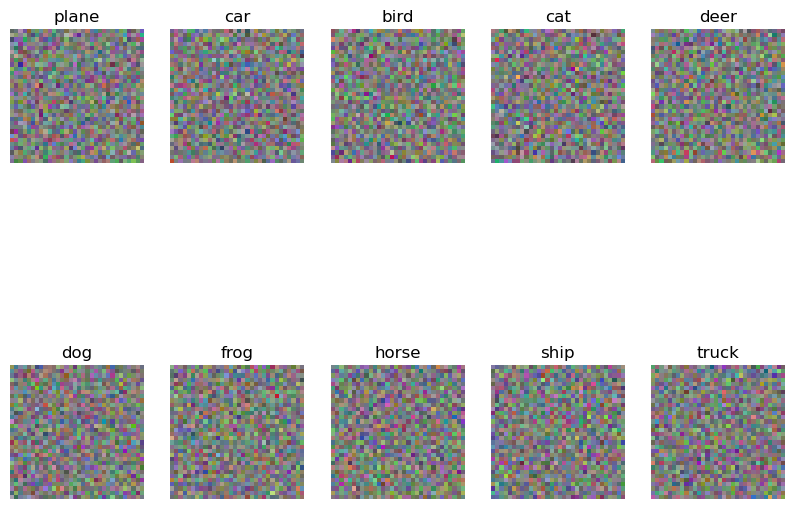

In [48]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])